In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext nb_black
%config InlineBackend.figure_format = "retina"

<IPython.core.display.Javascript object>

# ResNet + Semi-supervised

In [77]:
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchcontrib

import albumentations as A
from iterstrat import ml_stratifiers

<IPython.core.display.Javascript object>

## Setup

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


SEED = 42
seed_everything(SEED)

<IPython.core.display.Javascript object>

In [25]:
SIZE = 28
MEAN = 0.143
STD = 0.254
NUM_CLASSES = 10
PIXEL_COLS = [str(i) for i in range(784)]
DEVICE = "cuda"

<IPython.core.display.Javascript object>

## Data

In [5]:
DATA_PATH = Path("../input")
df = pd.read_csv(DATA_PATH / "train.csv")

<IPython.core.display.Javascript object>

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [8]:
y = df[["digit", "letter"]].values
kf = ml_stratifiers.MultilabelStratifiedKFold(n_splits=5)
for fold, (train_, valid_) in enumerate(kf.split(df, y=y)):
    np.save(f"./train_fold{fold}", train_)
    np.save(f"./valid_fold{fold}", valid_)

/home/isleof/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass shuffle=False, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<IPython.core.display.Javascript object>

In [29]:
class EMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, df, list_IDs, augs=None, label=True):
        self.list_IDs = list_IDs
        self.label = label

        self.images = df[PIXEL_COLS].values
        self.images = self.images.astype(np.uint8)
        self.images = self.images.reshape(-1, SIZE, SIZE, 1)

        if label:
            self.digits = df.digit.values

        if augs is None:
            self.augs = A.Compose(
                [A.Normalize(MEAN, STD, max_pixel_value=255.0, always_apply=True,),]
            )
        else:
            self.augs = augs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, item):
        # Get image
        index = self.list_IDs[item]
        image = self.images[index]

        # Augment image
        image = self.augs(image=image)["image"]

        # Convert to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float)
        image = image.permute(2, 0, 1)

        # Get labels and return
        if self.label:
            digit = self.digits[index]
            digit = torch.tensor(digit, dtype=torch.long)
            return image, digit
        else:
            return image

<IPython.core.display.Javascript object>

## Model

In [10]:
def init_cnn(m):
    if getattr(m, "bias", None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    for l in m.children():
        init_cnn(l)

<IPython.core.display.Javascript object>

### ResNet

In [11]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    """Pre-activation version of the BasicBlock"""

    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                )
            )
        else:
            self.shortcut = nn.Sequential()

    def forward(self, x):
        x = F.relu(self.bn1(x))
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(x)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    """Pre-activation version of the original Bottleneck module."""

    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

<IPython.core.display.Javascript object>

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(1, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024 * block.expansion, num_classes)
        init_cnn(self)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        avg_feats = F.adaptive_avg_pool2d(x, output_size=1)
        max_feats = F.adaptive_max_pool2d(x, output_size=1)
        x = torch.cat([avg_feats, max_feats], dim=1)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x


def ResNet18():
    return ResNet(PreActBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

<IPython.core.display.Javascript object>

## Train

In [18]:
def get_model(model_name):
    """Get model."""
    if model_name == "resnet18":
        model = ResNet18()
    elif model_name == "resnet34":
        model = ResNet34()
    elif model_name == "resnet50":
        model = ResNet50()
    else:
        raise RuntimeError("Unknown model name:", model_name)

    return model


def get_optimizer(optim_name, model, lr, wd, skip_list=["bias", "bn"]):
    """Get optimizer."""
    params = []
    exclude_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        elif any(skip in name for skip in skip_list):
            exclude_params.append(param)
        else:
            params.append(param)
    optim_params = [
        {"params": params, "weight_decay": wd},
        {"params": exclude_params, "weight_decay": 0.0},
    ]
    #     if optim_name == "radam":
    #         optimizer = optimizers.RAdam(optim_params, lr=lr)
    if optim_name == "adam":
        optimizer = torch.optim.Adam(optim_params, lr=lr)
    else:
        raise RuntimeError("Unknown optimizer:", optim_name)

    return optimizer

<IPython.core.display.Javascript object>

### Label smoothing

In [19]:
def loss_fn(outputs, targets):
    if len(targets.shape) == 1:
        return F.cross_entropy(outputs, targets)
    else:
        return torch.mean(torch.sum(-targets * F.log_softmax(outputs, dim=1), dim=1))


def label_smooth_loss_fn(outputs, targets, epsilon=0.1):
    num_classes = outputs.shape[1]
    device = outputs.device
    onehot = F.one_hot(targets, num_classes).to(dtype=torch.float, device=device)
    targets = (1 - epsilon) * onehot + torch.ones(onehot.shape).to(
        device
    ) * epsilon / num_classes
    return loss_fn(outputs, targets)

<IPython.core.display.Javascript object>

### CutMix

In [30]:
def rand_bbox(W, H, lam, device):
    cut_rat = torch.sqrt(1.0 - lam)
    cut_w = (W * cut_rat).type(torch.long)
    cut_h = (H * cut_rat).type(torch.long)
    # uniform
    cx = torch.randint(W, (1,), device=device)
    cy = torch.randint(H, (1,), device=device)
    x1 = torch.clamp(cx - cut_w // 2, 0, W)
    y1 = torch.clamp(cy - cut_h // 2, 0, H)
    x2 = torch.clamp(cx + cut_w // 2, 0, W)
    y2 = torch.clamp(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2


def cutmix_data(x, y, alpha=1.0, p=0.5):
    if np.random.random() > p:
        return x, y, torch.zeros_like(y), 1.0
    W, H = x.size(2), x.size(3)
    shuffle = torch.randperm(x.size(0), device=x.device)
    cutmix_x = x[shuffle]

    lam = torch.distributions.beta.Beta(alpha, alpha).sample().to(x.device)
    # lam = torch.tensor(np.random.beta(alpha, alpha), device=x.device)
    x1, y1, x2, y2 = rand_bbox(W, H, lam, x.device)
    cutmix_x[:, :, x1:x2, y1:y2] = x[shuffle, :, x1:x2, y1:y2]

    # Adjust lambda to match pixel ratio
    lam = 1 - ((x2 - x1) * (y2 - y1) / float(W * H)).item()
    y_a, y_b = y, y[shuffle]
    return cutmix_x, y_a, y_b, lam

<IPython.core.display.Javascript object>

In [35]:
def train(
    data_loader,
    model,
    optimizer,
    device,
    scaler,
    scheduler=None,
    label_smooth=False,
    cutmix=False,
):
    "Runs an epoch of training"
    correct = 0
    total = 0
    total_loss = 0

    model.train()
    for data in data_loader:

        # optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

        # Get data
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)

        if cutmix:
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)

        # Forward pass
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            criterion = label_smooth_loss_fn if label_smooth else loss_fn
            if cutmix or mixup:
                loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(
                    outputs, targets_b
                )
            else:
                loss = criterion(outputs, targets)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update scheduler
        if scheduler is not None:
            scheduler.step()

        # Record metrics
        preds = torch.argmax(outputs, dim=1)
        if cutmix:
            correct += (lam * preds.eq(targets_a).cpu().sum().float()) + (
                (1 - lam) * preds.eq(targets_b).cpu().sum().float()
            )
        else:
            correct += preds.eq(targets).cpu().sum().float()
        total += targets.size(0)
        total_loss += loss.item() * len(inputs)

    return total_loss / total, correct / total

<IPython.core.display.Javascript object>

In [36]:
def evaluate(data_loader, model, device, test=False):
    "Run evaluation loop"
    final_outputs = []
    final_targets = []
    total_loss = 0
    total = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for data in data_loader:

            # Get image batch
            if test:
                inputs = data
            else:
                inputs, targets = data
                targets = targets.to(device)
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)

            final_outputs.append(outputs.detach().cpu().numpy())
            if not test:
                final_targets.append(targets.detach().cpu().numpy())
                loss = loss_fn(outputs, targets)
                preds = torch.argmax(outputs, dim=1)
                total_loss += loss.item() * targets.size(0)
                total += targets.size(0)
                correct += preds.eq(targets).cpu().sum().float()

    final_outputs = np.concatenate(final_outputs, axis=0)

    if test:
        return final_outputs
    else:
        final_targets = np.concatenate(final_targets, axis=0)
        return final_outputs, final_targets, total_loss / total, correct / total

<IPython.core.display.Javascript object>

In [46]:
def run(
    model_name,
    optim_name,
    epochs,
    lr,
    wd,
    batch_size=64,
    augs=None,
    label_smooth=True,
    cutmix=False,
    device=DEVICE,
    swa=False,
    swa_lr=4e-4,
):
    oof = np.zeros((len(df), 10))
    targs = np.zeros(len(df))

    for fold in range(5):
        train_indices = np.load(f"./train_fold{fold}.npy")
        valid_indices = np.load(f"./valid_fold{fold}.npy")
        train_dataset = EMNISTDataset(df, train_indices, augs=augs)
        valid_dataset = EMNISTDataset(df, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=4 * batch_size, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr, wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        if swa:
            swa_start = int(epochs * 0.75)
            steps_per_epoch = len(train_dataset) // batch_size
            optimizer = torchcontrib.optim.SWA(
                optimizer,
                swa_start=swa_start * steps_per_epoch,
                swa_freq=steps_per_epoch,
                swa_lr=swa_lr,
            )

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            train_loss, train_accuracy = train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            valid_probs, valid_targs, valid_loss, valid_accuracy = evaluate(
                valid_loader, model, device
            )
            valid_accuracies.append(valid_accuracy)
            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        if swa:
            optimizer.swap_swa_sgd()
            optimizer.bn_update(train_loader, model, device)

        valid_probs, valid_targs, valid_loss, valid_accuracy = evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = scipy.special.softmax(valid_probs, axis=1)
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = (
            f"./swa_{model_name}_fold{fold}.pth"
            if swa
            else f"./{model_name}_fold{fold}.pth"
        )
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

Epoch=0, Train loss=6.78080, Valid loss=13035.81358, Train Accuracy=0.11401, Validation Accuracy=0.10024
Epoch=10, Train loss=2.60191, Valid loss=2.20809, Train Accuracy=0.21481, Validation Accuracy=0.17359
Epoch=20, Train loss=2.39962, Valid loss=7.41259, Train Accuracy=0.27059, Validation Accuracy=0.22983
Epoch=30, Train loss=2.41910, Valid loss=2.07472, Train Accuracy=0.26809, Validation Accuracy=0.32029
Epoch=40, Train loss=2.26159, Valid loss=1.57050, Train Accuracy=0.32299, Validation Accuracy=0.57946
Epoch=50, Train loss=2.08119, Valid loss=1.29332, Train Accuracy=0.39510, Validation Accuracy=0.70905
Epoch=60, Train loss=1.93183, Valid loss=1.33479, Train Accuracy=0.47066, Validation Accuracy=0.70416
Epoch=70, Train loss=1.76463, Valid loss=1.10986, Train Accuracy=0.55987, Validation Accuracy=0.75306
Epoch=80, Train loss=2.05107, Valid loss=1.57765, Train Accuracy=0.41335, Validation Accuracy=0.65281
Epoch=90, Train loss=1.81698, Valid loss=1.19176, Train Accuracy=0.54139, Valid

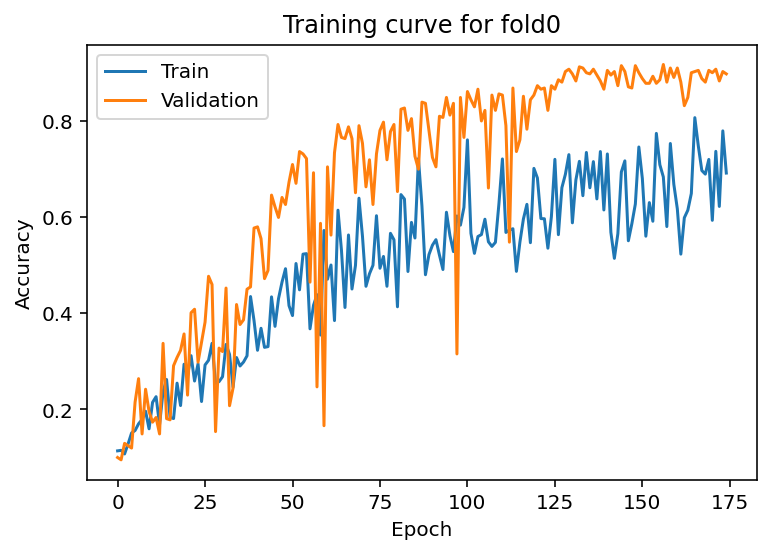

Epoch=0, Train loss=6.91795, Valid loss=2580.86262, Train Accuracy=0.11564, Validation Accuracy=0.08293
Epoch=10, Train loss=2.61989, Valid loss=2.13951, Train Accuracy=0.17771, Validation Accuracy=0.22927
Epoch=20, Train loss=2.37949, Valid loss=1.84718, Train Accuracy=0.25860, Validation Accuracy=0.46585
Epoch=30, Train loss=2.19249, Valid loss=1.66874, Train Accuracy=0.32181, Validation Accuracy=0.46585
Epoch=40, Train loss=2.23796, Valid loss=1.58600, Train Accuracy=0.35709, Validation Accuracy=0.49268
Epoch=50, Train loss=1.97210, Valid loss=20.77940, Train Accuracy=0.46211, Validation Accuracy=0.36829
Epoch=60, Train loss=1.88245, Valid loss=1.46753, Train Accuracy=0.49935, Validation Accuracy=0.55122
Epoch=70, Train loss=2.00938, Valid loss=1.41394, Train Accuracy=0.43198, Validation Accuracy=0.59268
Epoch=80, Train loss=1.92415, Valid loss=3.79517, Train Accuracy=0.49200, Validation Accuracy=0.39512
Epoch=90, Train loss=1.76060, Valid loss=1.84567, Train Accuracy=0.57132, Valid

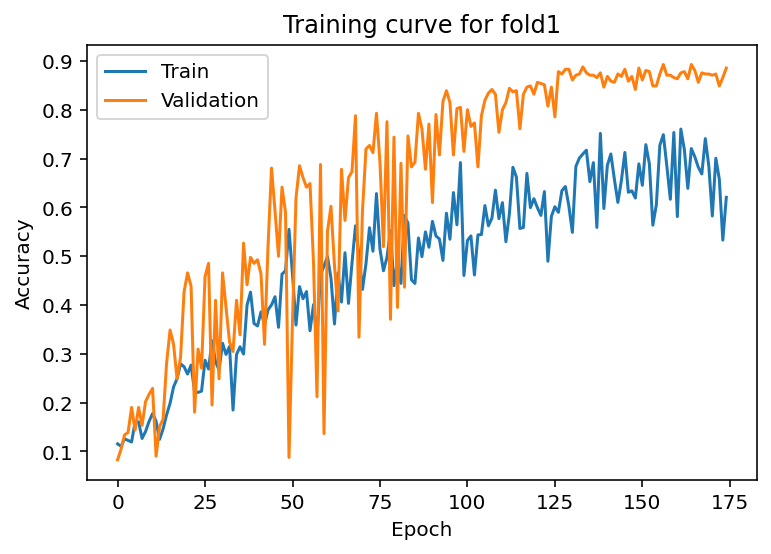

Epoch=0, Train loss=5.48205, Valid loss=31392.22707, Train Accuracy=0.10378, Validation Accuracy=0.10000
Epoch=10, Train loss=2.80957, Valid loss=6.54301, Train Accuracy=0.13892, Validation Accuracy=0.09756
Epoch=20, Train loss=2.55268, Valid loss=3.07042, Train Accuracy=0.17411, Validation Accuracy=0.19756
Epoch=30, Train loss=2.36261, Valid loss=2.66905, Train Accuracy=0.26198, Validation Accuracy=0.34390
Epoch=40, Train loss=2.22011, Valid loss=1.63728, Train Accuracy=0.34715, Validation Accuracy=0.54634
Epoch=50, Train loss=1.94507, Valid loss=72.41817, Train Accuracy=0.46865, Validation Accuracy=0.26585
Epoch=60, Train loss=2.07613, Valid loss=1.35224, Train Accuracy=0.41458, Validation Accuracy=0.67317
Epoch=70, Train loss=1.89658, Valid loss=1.35296, Train Accuracy=0.48420, Validation Accuracy=0.66098
Epoch=80, Train loss=1.91199, Valid loss=1.10128, Train Accuracy=0.48457, Validation Accuracy=0.76585
Epoch=90, Train loss=1.96122, Valid loss=1.22071, Train Accuracy=0.48315, Vali

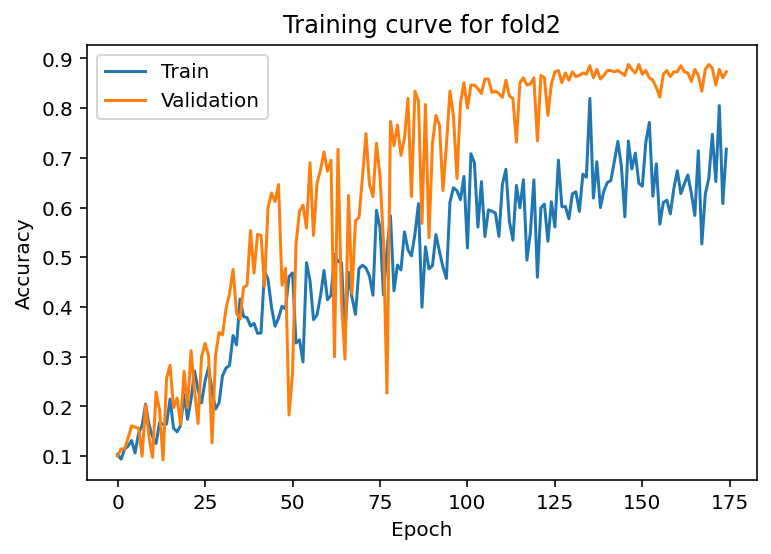

Epoch=0, Train loss=6.32432, Valid loss=14854.19982, Train Accuracy=0.08672, Validation Accuracy=0.11463
Epoch=10, Train loss=2.28788, Valid loss=1.98377, Train Accuracy=0.29837, Validation Accuracy=0.35854
Epoch=20, Train loss=2.31801, Valid loss=6.14945, Train Accuracy=0.30608, Validation Accuracy=0.36585
Epoch=30, Train loss=2.15472, Valid loss=1.38132, Train Accuracy=0.39633, Validation Accuracy=0.59756
Epoch=40, Train loss=2.41021, Valid loss=1.95095, Train Accuracy=0.24089, Validation Accuracy=0.26585
Epoch=50, Train loss=2.09601, Valid loss=1.46048, Train Accuracy=0.38463, Validation Accuracy=0.62439
Epoch=60, Train loss=1.98657, Valid loss=1.16277, Train Accuracy=0.45567, Validation Accuracy=0.69024
Epoch=70, Train loss=1.75276, Valid loss=0.91797, Train Accuracy=0.58516, Validation Accuracy=0.80000
Epoch=80, Train loss=1.72275, Valid loss=0.88546, Train Accuracy=0.60242, Validation Accuracy=0.83171
Epoch=90, Train loss=2.11798, Valid loss=1.58772, Train Accuracy=0.38406, Valid

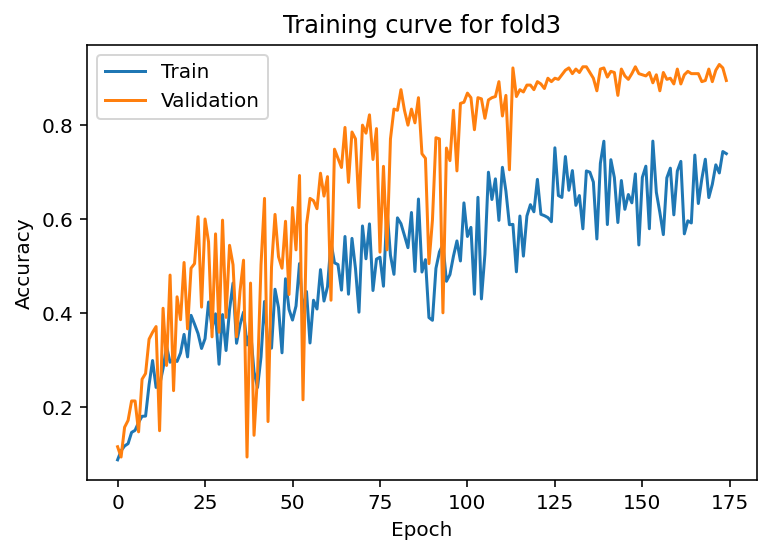

Epoch=0, Train loss=5.53685, Valid loss=4.04755, Train Accuracy=0.10348, Validation Accuracy=0.11980
Epoch=10, Train loss=2.75618, Valid loss=3.71316, Train Accuracy=0.18052, Validation Accuracy=0.13203
Epoch=20, Train loss=2.48493, Valid loss=4.27175, Train Accuracy=0.19226, Validation Accuracy=0.21027
Epoch=30, Train loss=2.47674, Valid loss=1.80584, Train Accuracy=0.27807, Validation Accuracy=0.41565
Epoch=40, Train loss=2.24634, Valid loss=1.66927, Train Accuracy=0.28338, Validation Accuracy=0.55012
Epoch=50, Train loss=1.94106, Valid loss=2.97514, Train Accuracy=0.46115, Validation Accuracy=0.44499
Epoch=60, Train loss=1.89320, Valid loss=1.32943, Train Accuracy=0.50435, Validation Accuracy=0.71638
Epoch=70, Train loss=1.64292, Valid loss=1.00342, Train Accuracy=0.61229, Validation Accuracy=0.76039
Epoch=80, Train loss=2.04660, Valid loss=1.03744, Train Accuracy=0.44209, Validation Accuracy=0.80440
Epoch=90, Train loss=1.58650, Valid loss=3.23874, Train Accuracy=0.63771, Validatio

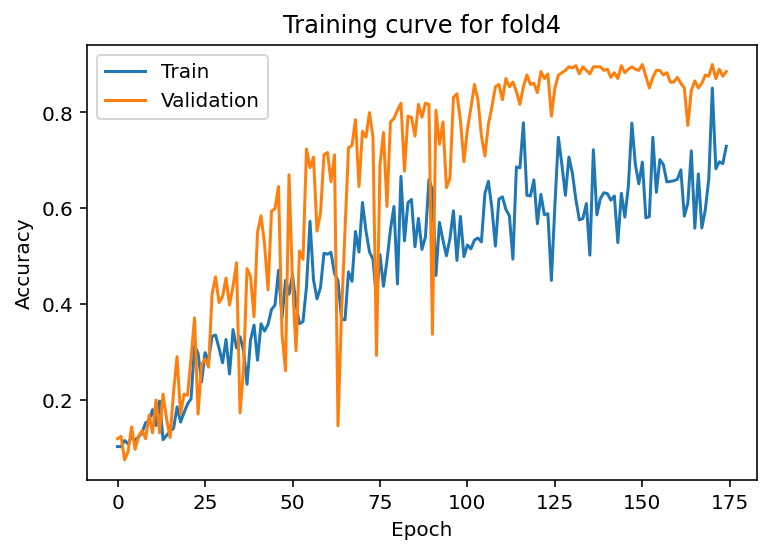

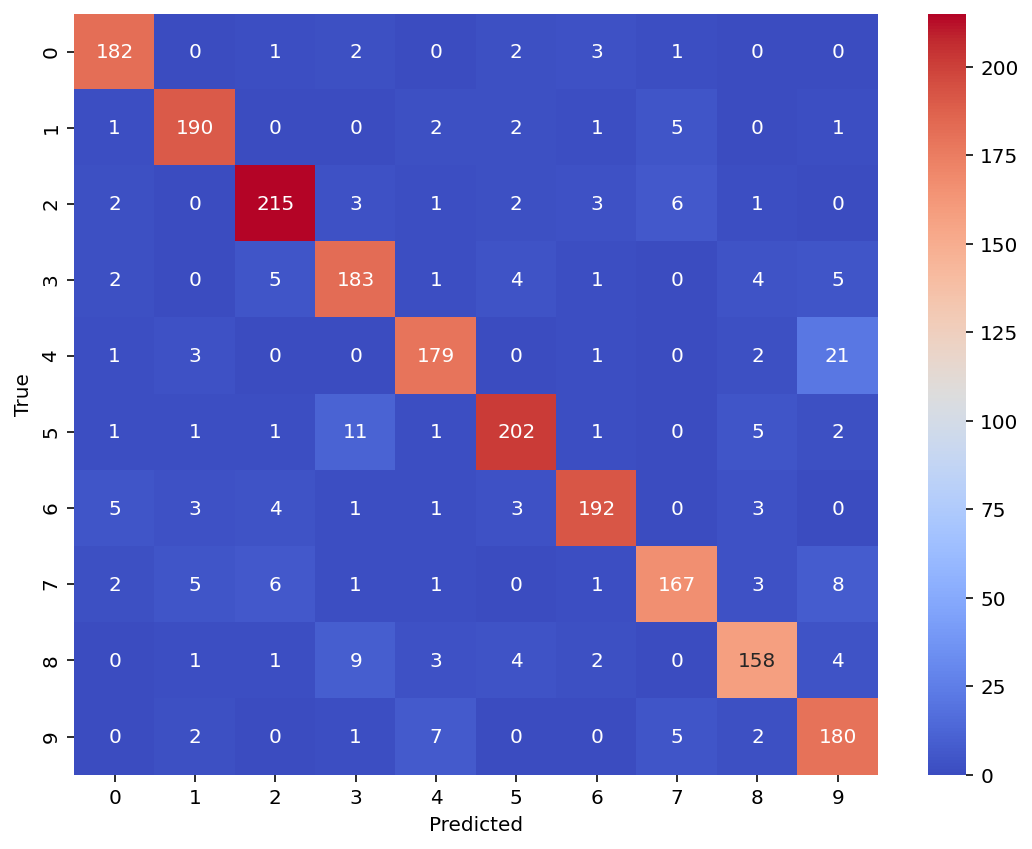

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       191
         1.0       0.93      0.94      0.93       202
         2.0       0.92      0.92      0.92       233
         3.0       0.87      0.89      0.88       205
         4.0       0.91      0.86      0.89       207
         5.0       0.92      0.90      0.91       225
         6.0       0.94      0.91      0.92       212
         7.0       0.91      0.86      0.88       194
         8.0       0.89      0.87      0.88       182
         9.0       0.81      0.91      0.86       197

    accuracy                           0.90      2048
   macro avg       0.90      0.90      0.90      2048
weighted avg       0.90      0.90      0.90      2048

CV Accuracy Score=0.90234375
model=resnet34, optimizer=adam, epochs=175, lr=0.003, wd=0.0005
CPU times: user 14min 6s, sys: 1min 59s, total: 16min 6s
Wall time: 16min 45s


<IPython.core.display.Javascript object>

In [82]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 175
batch_size = 64
lr = 3e-3
wd = 5e-4
swa_lr = 2e-4
oof, targs = run(model_name, optim_name, epochs, lr, wd, batch_size, augs, label_smooth=True, cutmix=True, swa=True, swa_lr=swa_lr)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

## Inference

In [49]:
def get_tta(
    model, test_df, augs, device, batch_size=1024, n=4, beta=0.25, use_max=False
):
    ds = EMNISTDataset(test_df, np.arange(len(test_df)), label=False)
    dl = torch.utils.data.DataLoader(
        ds, batch_size=batch_size, num_workers=4, pin_memory=True
    )
    logits = evaluate(dl, model, device, test=True)

    aug_ds = EMNISTDataset(test_df, np.arange(len(test_df)), augs=augs, label=False)
    aug_dl = torch.utils.data.DataLoader(
        aug_ds, batch_size=batch_size, num_workers=4, pin_memory=True
    )
    aug_logits = [evaluate(aug_dl, model, device, test=True) for i in range(n)]
    aug_logits = np.concatenate(aug_logits, axis=0)
    aug_logits = aug_logits.max(axis=0) if use_max else aug_logits.mean(axis=0)

    if use_max:
        return np.concatenate([logits, aug_logits], axis=0).max(axis=0)
    else:
        return beta * aug_logits + (1 - beta) * logits

<IPython.core.display.Javascript object>

In [54]:
def infer(
    model_names,
    checkpoints,
    test_df,
    augs=None,
    batch_size=1024,
    device=DEVICE,
    tta=False,
):
    output = np.zeros((len(test_df), 10))

    test_dataset = EMNISTDataset(
        test_df, np.arange(len(test_df)), augs=augs, label=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True
    )

    for model_name, checkpoint in zip(model_names, checkpoints):
        model = get_model(model_name).to(device)
        model.load_state_dict(torch.load(checkpoint))

        if tta:
            logits = get_tta(model, test_df, augs, device, batch_size)
        else:
            logits = evaluate(test_loader, model, device, test=True)

        probs = scipy.special.softmax(logits, axis=1)
        output += probs / len(model_names)

    return output

<IPython.core.display.Javascript object>

In [61]:
checkpoints = [f"./swa_resnet34_fold{fold}.pth" for fold in range(5)]
model_names = ["resnet34",] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = infer(model_names, checkpoints, test_df, device=DEVICE)
test_preds = np.argmax(test_probs, axis=1)
np.save("swa_probs.npy", test_probs)

<IPython.core.display.Javascript object>

In [62]:
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("swa_submit.csv", index=False)

<IPython.core.display.Javascript object>

## Pseudo-labeling

In [57]:
test_probs = np.load("swa_probs.npy")
test_preds = np.argmax(test_probs, axis=1)

<IPython.core.display.Javascript object>

In [63]:
thresh = 0.65
maxprobs = np.take_along_axis(test_probs, test_preds[:, None], axis=1)
(maxprobs > thresh).sum()

8083

<IPython.core.display.Javascript object>

In [64]:
test_df["prob"] = maxprobs
test_df["digit"] = test_preds

<IPython.core.display.Javascript object>

In [65]:
pl = test_df[test_df.prob > thresh].reset_index(drop=True)
pl = pl.drop("prob", axis=1)
pl = pd.concat([pl, df], axis=0)
pl = pl.sample(frac=1.0).reset_index(drop=True)
pl.to_csv("./pl_resnet34_065.csv", index=False)

<IPython.core.display.Javascript object>

In [70]:
y = pl[["digit", "letter"]].values
kf = ml_stratifiers.MultilabelStratifiedKFold(n_splits=5)
for fold, (train_, valid_) in enumerate(kf.split(pl, y=y)):
    np.save(f"./train_fold{fold}_pl", train_)
    np.save(f"./valid_fold{fold}_pl", valid_)

<IPython.core.display.Javascript object>

In [78]:
def run_pl_swa(
    pl,
    model_name,
    optim_name,
    epochs,
    lr,
    swa_lr,
    wd,
    batch_size=128,
    augs=None,
    label_smooth=True,
    cutmix=False,
    device=DEVICE,
    seed=SEED,
):
    oof = np.zeros((len(pl), 10))
    targs = np.zeros(len(pl))

    for fold in range(5):
        train_indices = np.load(f"./train_fold{fold}_pl.npy")
        valid_indices = np.load(f"./valid_fold{fold}_pl.npy")
        train_dataset = EMNISTDataset(pl, train_indices, augs=augs)
        valid_dataset = EMNISTDataset(pl, valid_indices)
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=4 * batch_size, num_workers=4, pin_memory=True
        )

        model = get_model(model_name).to(device)
        optimizer = get_optimizer(optim_name, model, lr, wd)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        scaler = torch.cuda.amp.GradScaler()

        swa_start = int(epochs * 0.75)
        steps_per_epoch = len(train_dataset) // batch_size
        optimizer = torchcontrib.optim.SWA(
            optimizer,
            swa_start=swa_start * steps_per_epoch,
            swa_freq=steps_per_epoch,
            swa_lr=swa_lr,
        )

        train_accuracies = []
        valid_accuracies = []

        for epoch in range(epochs):
            # Train
            train_loss, train_accuracy = train(
                train_loader,
                model,
                optimizer,
                device,
                scaler,
                label_smooth=label_smooth,
                cutmix=cutmix,
            )
            train_accuracies.append(train_accuracy)
            scheduler.step()

            # Validate
            if epoch + 1 >= swa_start:
                optimizer.swap_swa_sgd()
                optimizer.bn_update(train_loader, model, device)
                _, _, valid_loss, valid_accuracy = evaluate(valid_loader, model, device)
                optimizer.swap_swa_sgd()
            else:
                _, _, valid_loss, valid_accuracy = evaluate(valid_loader, model, device)
            valid_accuracies.append(valid_accuracy)

            if epoch % 10 == 0:
                print(
                    f"Epoch={epoch}, Train loss={train_loss:.5f}, Valid loss={valid_loss:.5f}, Train Accuracy={train_accuracy:.5f}, Validation Accuracy={valid_accuracy:.5f}"
                )

        optimizer.swap_swa_sgd()
        optimizer.bn_update(train_loader, model, device)

        valid_logits, valid_targs, valid_loss, valid_accuracy = evaluate(
            valid_loader, model, device
        )
        print(
            f"Fold={fold}, Valid loss={valid_loss:.5f}, Valid Accuracy={valid_accuracy:.5f}"
        )

        # oof prediction
        oof[valid_indices] = valid_logits
        targs[valid_indices] = valid_targs

        # Save model
        checkpoint = f"./swa_{model_name}_fold{fold}_pl_seed{seed}.pth"
        torch.save(model.state_dict(), checkpoint)

        # Plot training curve
        rng = np.arange(len(train_accuracies))
        plt.plot(rng, train_accuracies, label="Train")
        plt.plot(rng, valid_accuracies, label="Validation")
        plt.title(f"Training curve for fold{fold}")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()

    oof = scipy.special.softmax(oof, axis=1)

    # Confusion matrix
    conf = metrics.confusion_matrix(targs, np.argmax(oof, axis=1))
    plt.figure(figsize=(9, 7))
    sns.heatmap(conf, cmap="coolwarm", annot=True, fmt="d")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

    # Classification report
    print(metrics.classification_report(targs, np.argmax(oof, axis=1)))

    return oof, targs

<IPython.core.display.Javascript object>

Epoch=0, Train loss=3.21424, Valid loss=1.49905, Train Accuracy=0.21316, Validation Accuracy=0.47730
Epoch=10, Train loss=1.50028, Valid loss=0.88464, Train Accuracy=0.70592, Validation Accuracy=0.85884
Epoch=20, Train loss=1.56302, Valid loss=0.47240, Train Accuracy=0.68077, Validation Accuracy=0.97730
Epoch=30, Train loss=1.51070, Valid loss=0.40721, Train Accuracy=0.70787, Validation Accuracy=0.97433
Epoch=40, Train loss=1.40214, Valid loss=0.35723, Train Accuracy=0.73312, Validation Accuracy=0.97730
Epoch=50, Train loss=1.74743, Valid loss=0.63792, Train Accuracy=0.60161, Validation Accuracy=0.97581
Epoch=60, Train loss=1.62489, Valid loss=0.76060, Train Accuracy=0.64419, Validation Accuracy=0.94669
Epoch=70, Train loss=1.51701, Valid loss=0.44377, Train Accuracy=0.69341, Validation Accuracy=0.98223
Epoch=80, Train loss=1.67004, Valid loss=0.64936, Train Accuracy=0.62377, Validation Accuracy=0.98026
Epoch=90, Train loss=1.48995, Valid loss=0.58530, Train Accuracy=0.69749, Validatio

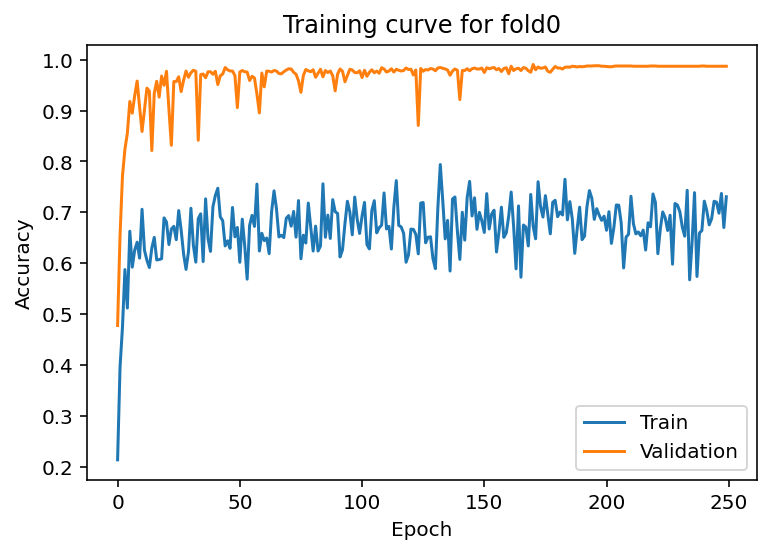

Epoch=0, Train loss=3.18661, Valid loss=1.67751, Train Accuracy=0.22575, Validation Accuracy=0.40967
Epoch=10, Train loss=1.59749, Valid loss=0.36835, Train Accuracy=0.66825, Validation Accuracy=0.95656
Epoch=20, Train loss=1.63837, Valid loss=0.58503, Train Accuracy=0.65150, Validation Accuracy=0.96841
Epoch=30, Train loss=1.80926, Valid loss=1.15688, Train Accuracy=0.57213, Validation Accuracy=0.85637
Epoch=40, Train loss=1.55898, Valid loss=0.70145, Train Accuracy=0.68037, Validation Accuracy=0.95311
Epoch=50, Train loss=1.85075, Valid loss=0.75434, Train Accuracy=0.54374, Validation Accuracy=0.94620
Epoch=60, Train loss=1.64580, Valid loss=0.75307, Train Accuracy=0.64897, Validation Accuracy=0.96150
Epoch=70, Train loss=1.50581, Valid loss=0.46827, Train Accuracy=0.70273, Validation Accuracy=0.97631
Epoch=80, Train loss=1.57384, Valid loss=0.46134, Train Accuracy=0.66708, Validation Accuracy=0.97680
Epoch=90, Train loss=1.53416, Valid loss=0.46177, Train Accuracy=0.68709, Validatio

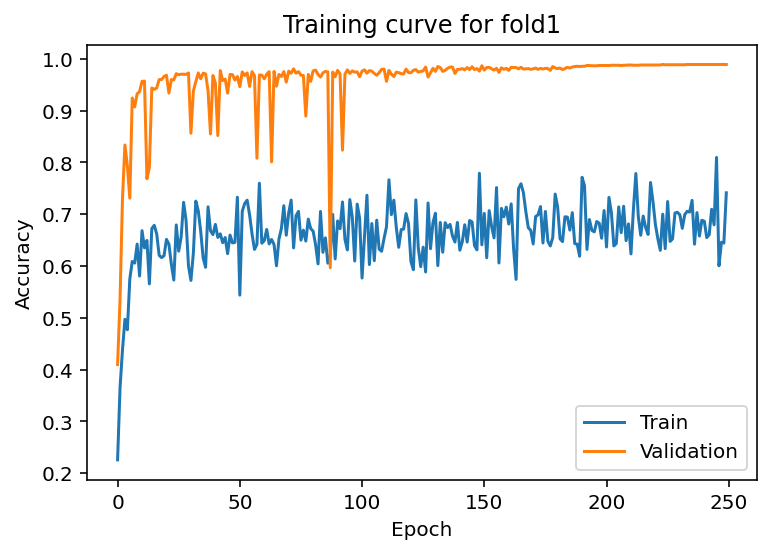

Epoch=0, Train loss=3.30123, Valid loss=1.69207, Train Accuracy=0.20391, Validation Accuracy=0.41835
Epoch=10, Train loss=1.57442, Valid loss=1.46059, Train Accuracy=0.67970, Validation Accuracy=0.62062
Epoch=20, Train loss=1.58045, Valid loss=0.79471, Train Accuracy=0.67610, Validation Accuracy=0.96991
Epoch=30, Train loss=1.40511, Valid loss=0.41492, Train Accuracy=0.74122, Validation Accuracy=0.96497
Epoch=40, Train loss=1.59033, Valid loss=0.75689, Train Accuracy=0.65708, Validation Accuracy=0.94573
Epoch=50, Train loss=1.44770, Valid loss=0.56501, Train Accuracy=0.71386, Validation Accuracy=0.97484
Epoch=60, Train loss=1.68663, Valid loss=0.57466, Train Accuracy=0.62526, Validation Accuracy=0.97977
Epoch=70, Train loss=1.53286, Valid loss=0.65931, Train Accuracy=0.68355, Validation Accuracy=0.97879
Epoch=80, Train loss=1.47736, Valid loss=0.56463, Train Accuracy=0.70785, Validation Accuracy=0.96053
Epoch=90, Train loss=1.63670, Valid loss=0.60951, Train Accuracy=0.63327, Validatio

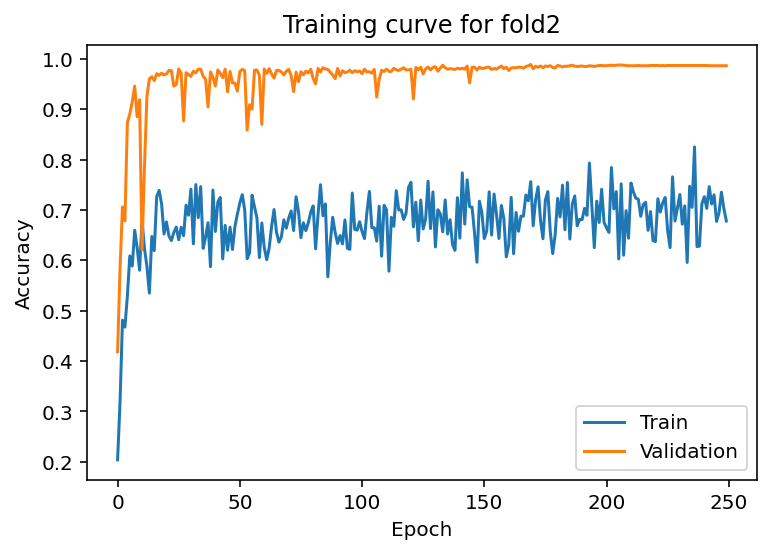

Epoch=0, Train loss=3.33273, Valid loss=1.52270, Train Accuracy=0.22376, Validation Accuracy=0.52468
Epoch=10, Train loss=1.66916, Valid loss=0.48371, Train Accuracy=0.63590, Validation Accuracy=0.95706
Epoch=20, Train loss=1.72077, Valid loss=0.61889, Train Accuracy=0.61609, Validation Accuracy=0.96150
Epoch=30, Train loss=1.59609, Valid loss=0.59316, Train Accuracy=0.65821, Validation Accuracy=0.97483
Epoch=40, Train loss=1.57765, Valid loss=0.65937, Train Accuracy=0.67039, Validation Accuracy=0.97137
Epoch=50, Train loss=1.51869, Valid loss=0.69234, Train Accuracy=0.69179, Validation Accuracy=0.96002
Epoch=60, Train loss=1.61375, Valid loss=0.61069, Train Accuracy=0.65760, Validation Accuracy=0.96496
Epoch=70, Train loss=1.68454, Valid loss=0.57440, Train Accuracy=0.62553, Validation Accuracy=0.97631
Epoch=80, Train loss=1.70329, Valid loss=0.77110, Train Accuracy=0.62206, Validation Accuracy=0.92646
Epoch=90, Train loss=1.46631, Valid loss=0.40232, Train Accuracy=0.70760, Validatio

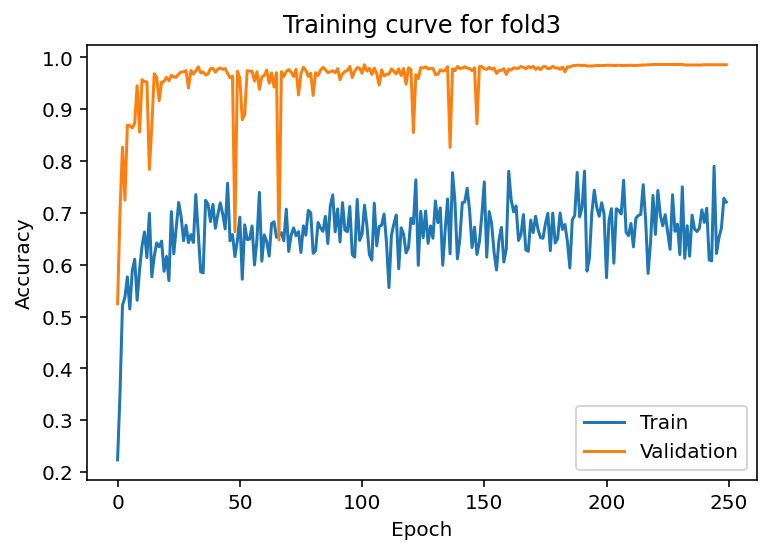

Epoch=0, Train loss=2.96461, Valid loss=1.49843, Train Accuracy=0.24036, Validation Accuracy=0.49260
Epoch=10, Train loss=1.62468, Valid loss=0.75918, Train Accuracy=0.65590, Validation Accuracy=0.91708
Epoch=20, Train loss=1.65720, Valid loss=0.58905, Train Accuracy=0.64224, Validation Accuracy=0.96644
Epoch=30, Train loss=1.60873, Valid loss=0.42878, Train Accuracy=0.66552, Validation Accuracy=0.97779
Epoch=40, Train loss=1.65830, Valid loss=0.48898, Train Accuracy=0.64239, Validation Accuracy=0.97285
Epoch=50, Train loss=1.54866, Valid loss=0.43670, Train Accuracy=0.67823, Validation Accuracy=0.97878
Epoch=60, Train loss=1.53846, Valid loss=0.38516, Train Accuracy=0.68293, Validation Accuracy=0.97581
Epoch=70, Train loss=1.53622, Valid loss=0.43075, Train Accuracy=0.68128, Validation Accuracy=0.97828
Epoch=80, Train loss=1.59910, Valid loss=0.65850, Train Accuracy=0.65490, Validation Accuracy=0.96742
Epoch=90, Train loss=1.45655, Valid loss=0.45529, Train Accuracy=0.71434, Validatio

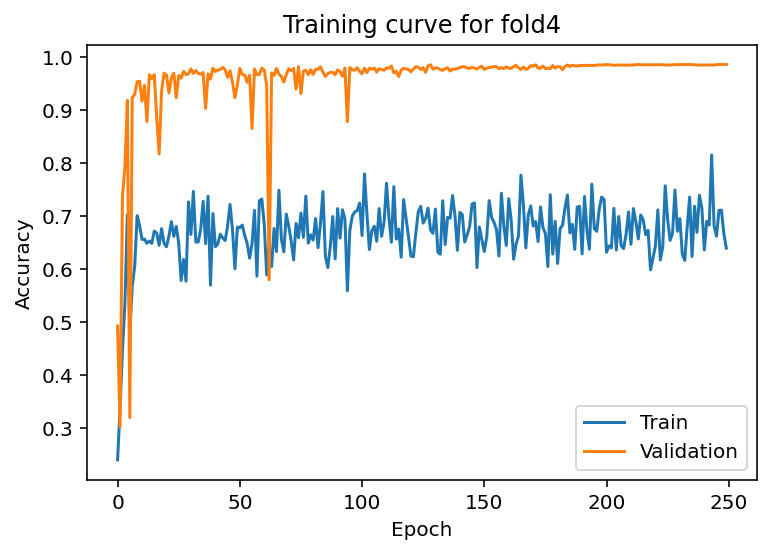

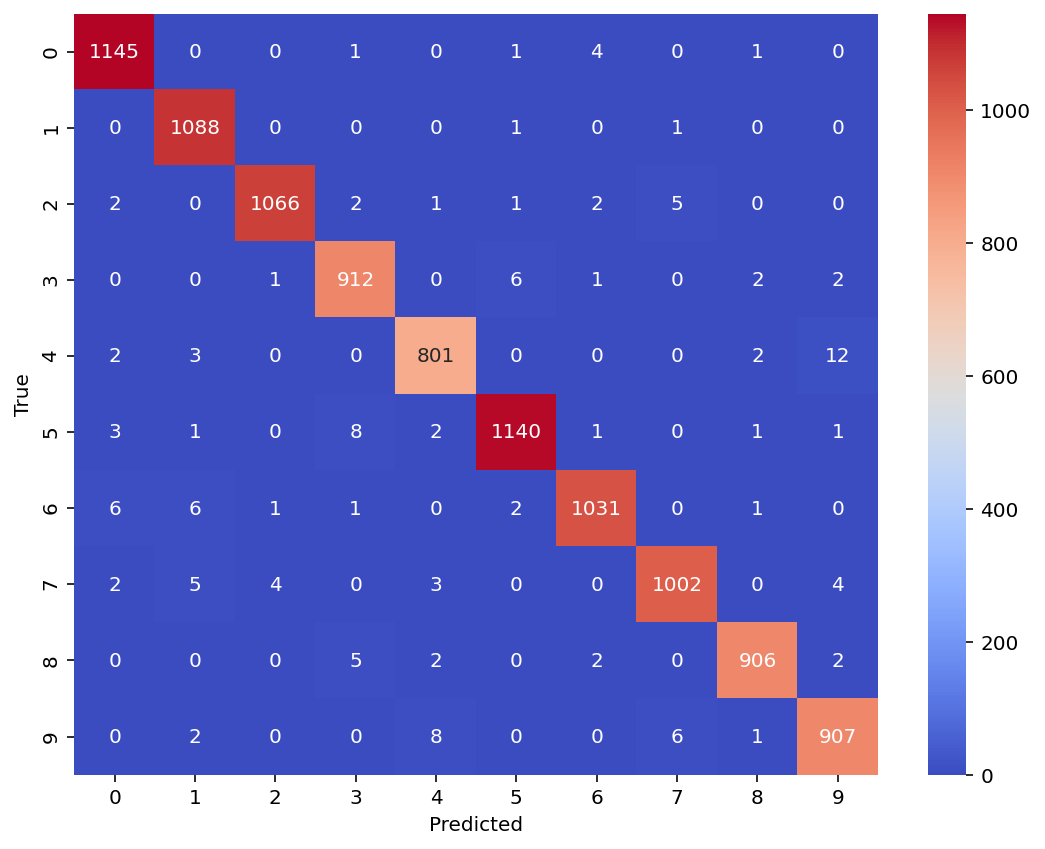

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1152
         1.0       0.98      1.00      0.99      1090
         2.0       0.99      0.99      0.99      1079
         3.0       0.98      0.99      0.98       924
         4.0       0.98      0.98      0.98       820
         5.0       0.99      0.99      0.99      1157
         6.0       0.99      0.98      0.99      1048
         7.0       0.99      0.98      0.99      1020
         8.0       0.99      0.99      0.99       917
         9.0       0.98      0.98      0.98       924

    accuracy                           0.99     10131
   macro avg       0.99      0.99      0.99     10131
weighted avg       0.99      0.99      0.99     10131

CV Accuracy Score=0.9868719770999901
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005
CPU times: user 1h 20min 11s, sys: 3min 26s, total: 1h 23min 38s
Wall time: 1h 24min 7s


<IPython.core.display.Javascript object>

In [79]:
%%time
augs = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.Normalize(mean=0.143, std=0.254, max_pixel_value=255.0, always_apply=True,),
])
model_name = "resnet34"
optim_name = "adam"
epochs = 250
lr = 5e-4
wd = 5e-4
swa_lr = 5e-5
batch_size = 128

oof, targs = run_pl_swa(pl, model_name, optim_name, epochs, lr, swa_lr, wd, batch_size, augs, label_smooth=True, cutmix=True, device=DEVICE)
preds = np.argmax(oof, axis=1)
accuracy = metrics.accuracy_score(targs, preds)
print(f"CV Accuracy Score={accuracy}")
print(f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}")

In [81]:
checkpoints = [f"./swa_resnet34_fold{fold}_pl_seed{SEED}.pth" for fold in range(5)]
model_names = ["resnet34"] * 5
test_df = pd.read_csv(DATA_PATH / "test.csv")
test_probs = infer(
    model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True
)
test_preds = np.argmax(test_probs, axis=1)
np.save("swa_tta_pl_probs_resnet34.npy", test_probs)

<IPython.core.display.Javascript object>

## Ensemble

Epoch=0, Train loss=3.34287, Valid loss=1.95192, Train Accuracy=0.23712, Validation Accuracy=0.38006
Epoch=10, Train loss=1.61339, Valid loss=0.59313, Train Accuracy=0.65573, Validation Accuracy=0.95607
Epoch=20, Train loss=1.64606, Valid loss=0.73988, Train Accuracy=0.65277, Validation Accuracy=0.93929
Epoch=30, Train loss=1.41374, Valid loss=0.35992, Train Accuracy=0.73743, Validation Accuracy=0.97680
Epoch=40, Train loss=1.75084, Valid loss=0.82715, Train Accuracy=0.60913, Validation Accuracy=0.90819
Epoch=50, Train loss=1.39185, Valid loss=0.42312, Train Accuracy=0.73942, Validation Accuracy=0.98371
Epoch=60, Train loss=1.37081, Valid loss=0.46148, Train Accuracy=0.74727, Validation Accuracy=0.96841
Epoch=70, Train loss=1.68102, Valid loss=0.54171, Train Accuracy=0.61926, Validation Accuracy=0.97779
Epoch=80, Train loss=1.66443, Valid loss=0.64113, Train Accuracy=0.63217, Validation Accuracy=0.96545
Epoch=90, Train loss=1.56869, Valid loss=0.53876, Train Accuracy=0.67077, Validatio

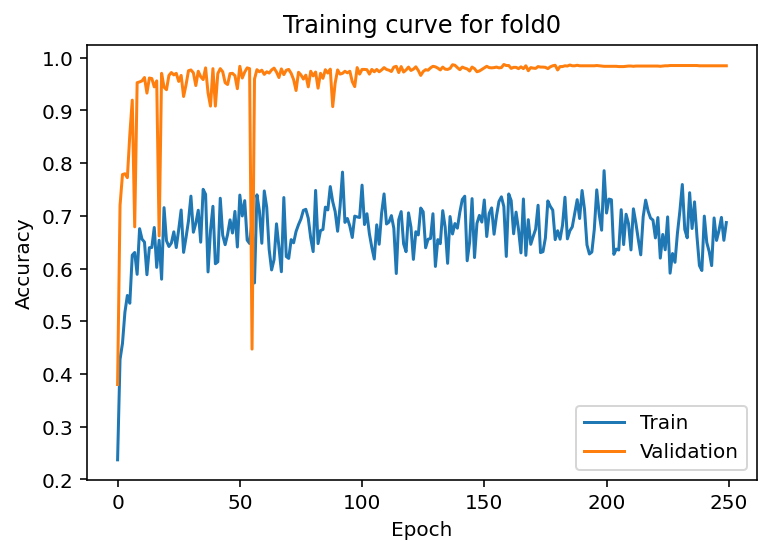

Epoch=0, Train loss=3.16588, Valid loss=1.39847, Train Accuracy=0.22882, Validation Accuracy=0.52912
Epoch=10, Train loss=1.65399, Valid loss=1.09911, Train Accuracy=0.64700, Validation Accuracy=0.82330
Epoch=20, Train loss=1.56744, Valid loss=0.68194, Train Accuracy=0.68556, Validation Accuracy=0.96644
Epoch=30, Train loss=1.71097, Valid loss=0.48240, Train Accuracy=0.62393, Validation Accuracy=0.96841
Epoch=40, Train loss=1.73563, Valid loss=0.83315, Train Accuracy=0.60682, Validation Accuracy=0.94719
Epoch=50, Train loss=1.63062, Valid loss=0.70205, Train Accuracy=0.65146, Validation Accuracy=0.96890
Epoch=60, Train loss=1.61058, Valid loss=0.46969, Train Accuracy=0.65695, Validation Accuracy=0.97730
Epoch=70, Train loss=1.68027, Valid loss=0.56377, Train Accuracy=0.62005, Validation Accuracy=0.97927
Epoch=80, Train loss=1.49643, Valid loss=0.71149, Train Accuracy=0.69697, Validation Accuracy=0.94965
Epoch=90, Train loss=1.81201, Valid loss=1.04302, Train Accuracy=0.55410, Validatio

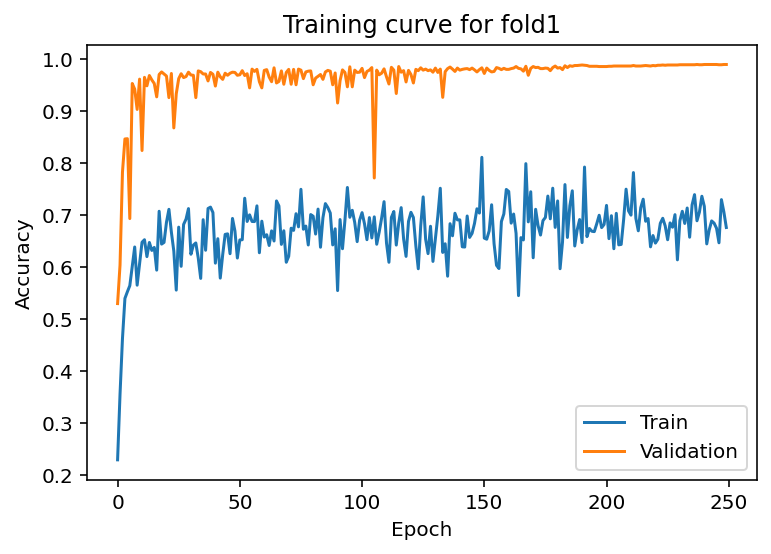

Epoch=0, Train loss=3.43807, Valid loss=2.35957, Train Accuracy=0.23270, Validation Accuracy=0.19832
Epoch=10, Train loss=1.66795, Valid loss=0.58158, Train Accuracy=0.62754, Validation Accuracy=0.95017
Epoch=20, Train loss=1.62638, Valid loss=0.80593, Train Accuracy=0.66040, Validation Accuracy=0.93537
Epoch=30, Train loss=1.34982, Valid loss=0.45690, Train Accuracy=0.75803, Validation Accuracy=0.97484
Epoch=40, Train loss=1.70471, Valid loss=0.48156, Train Accuracy=0.61951, Validation Accuracy=0.97583
Epoch=50, Train loss=1.53091, Valid loss=0.52744, Train Accuracy=0.68372, Validation Accuracy=0.97287
Epoch=60, Train loss=1.73383, Valid loss=0.75762, Train Accuracy=0.60501, Validation Accuracy=0.91613
Epoch=70, Train loss=1.68211, Valid loss=0.66630, Train Accuracy=0.62120, Validation Accuracy=0.97435
Epoch=80, Train loss=1.46649, Valid loss=0.38423, Train Accuracy=0.70692, Validation Accuracy=0.97583
Epoch=90, Train loss=1.58328, Valid loss=0.75746, Train Accuracy=0.66401, Validatio

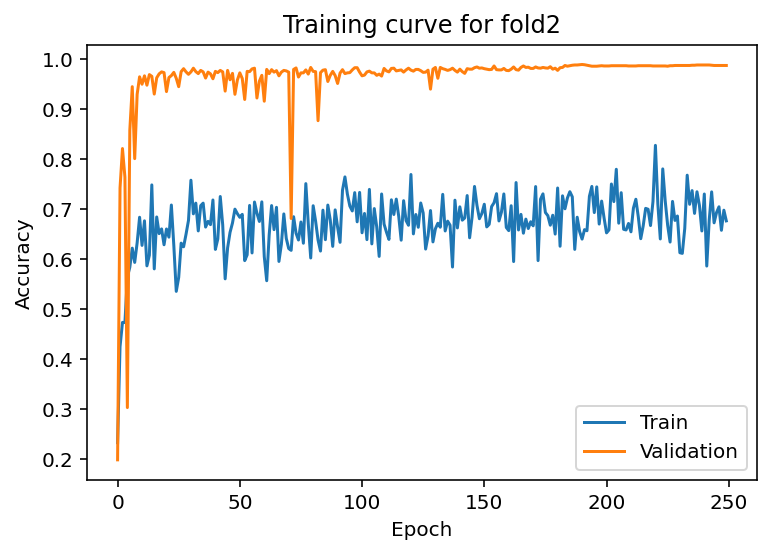

Epoch=0, Train loss=3.03418, Valid loss=1.51513, Train Accuracy=0.22581, Validation Accuracy=0.46644
Epoch=10, Train loss=1.60125, Valid loss=0.52029, Train Accuracy=0.66090, Validation Accuracy=0.96298
Epoch=20, Train loss=1.72919, Valid loss=0.76600, Train Accuracy=0.61380, Validation Accuracy=0.96298
Epoch=30, Train loss=1.51135, Valid loss=0.72548, Train Accuracy=0.70425, Validation Accuracy=0.94965
Epoch=40, Train loss=1.51433, Valid loss=0.44617, Train Accuracy=0.69635, Validation Accuracy=0.97828
Epoch=50, Train loss=1.75031, Valid loss=0.91498, Train Accuracy=0.59273, Validation Accuracy=0.89191
Epoch=60, Train loss=1.41185, Valid loss=0.43558, Train Accuracy=0.72982, Validation Accuracy=0.97483
Epoch=70, Train loss=1.50814, Valid loss=0.48388, Train Accuracy=0.69306, Validation Accuracy=0.97137
Epoch=80, Train loss=1.66899, Valid loss=0.68499, Train Accuracy=0.62819, Validation Accuracy=0.96940
Epoch=90, Train loss=1.52451, Valid loss=0.54984, Train Accuracy=0.68455, Validatio

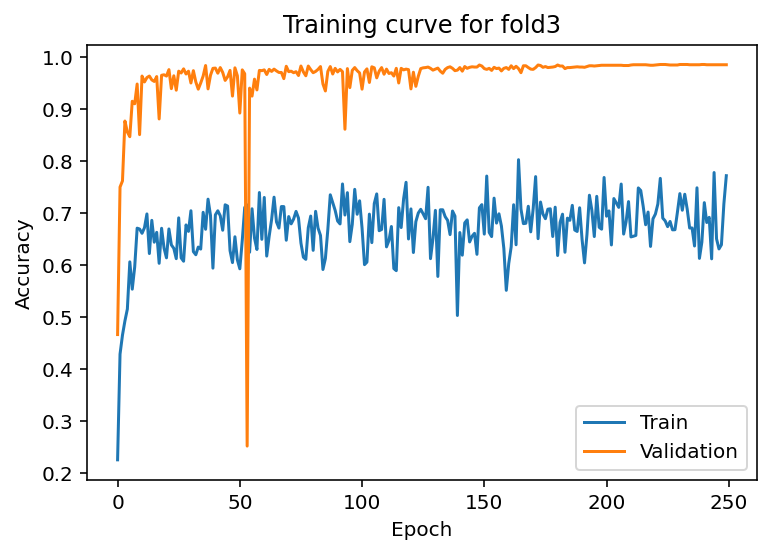

Epoch=0, Train loss=3.29257, Valid loss=1.91377, Train Accuracy=0.20921, Validation Accuracy=0.45114
Epoch=10, Train loss=1.82223, Valid loss=0.64605, Train Accuracy=0.58359, Validation Accuracy=0.95805
Epoch=20, Train loss=1.75618, Valid loss=2.56020, Train Accuracy=0.61101, Validation Accuracy=0.81540
Epoch=30, Train loss=1.62227, Valid loss=0.84129, Train Accuracy=0.65690, Validation Accuracy=0.89141
Epoch=40, Train loss=1.61462, Valid loss=0.70093, Train Accuracy=0.65760, Validation Accuracy=0.96397
Epoch=50, Train loss=1.61421, Valid loss=0.76217, Train Accuracy=0.65133, Validation Accuracy=0.96545
Epoch=60, Train loss=1.47002, Valid loss=0.50602, Train Accuracy=0.71590, Validation Accuracy=0.97433
Epoch=70, Train loss=1.57959, Valid loss=0.49639, Train Accuracy=0.66932, Validation Accuracy=0.97433
Epoch=80, Train loss=1.48209, Valid loss=0.39153, Train Accuracy=0.70047, Validation Accuracy=0.98075
Epoch=90, Train loss=1.47893, Valid loss=0.48644, Train Accuracy=0.70231, Validatio

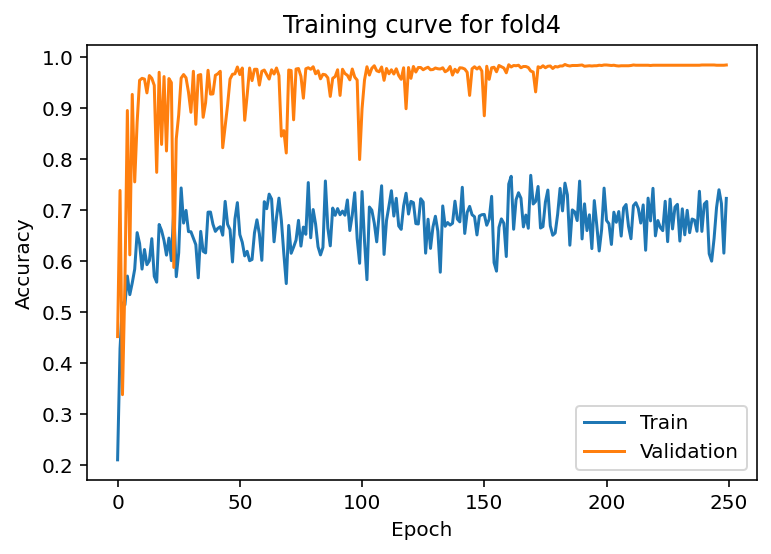

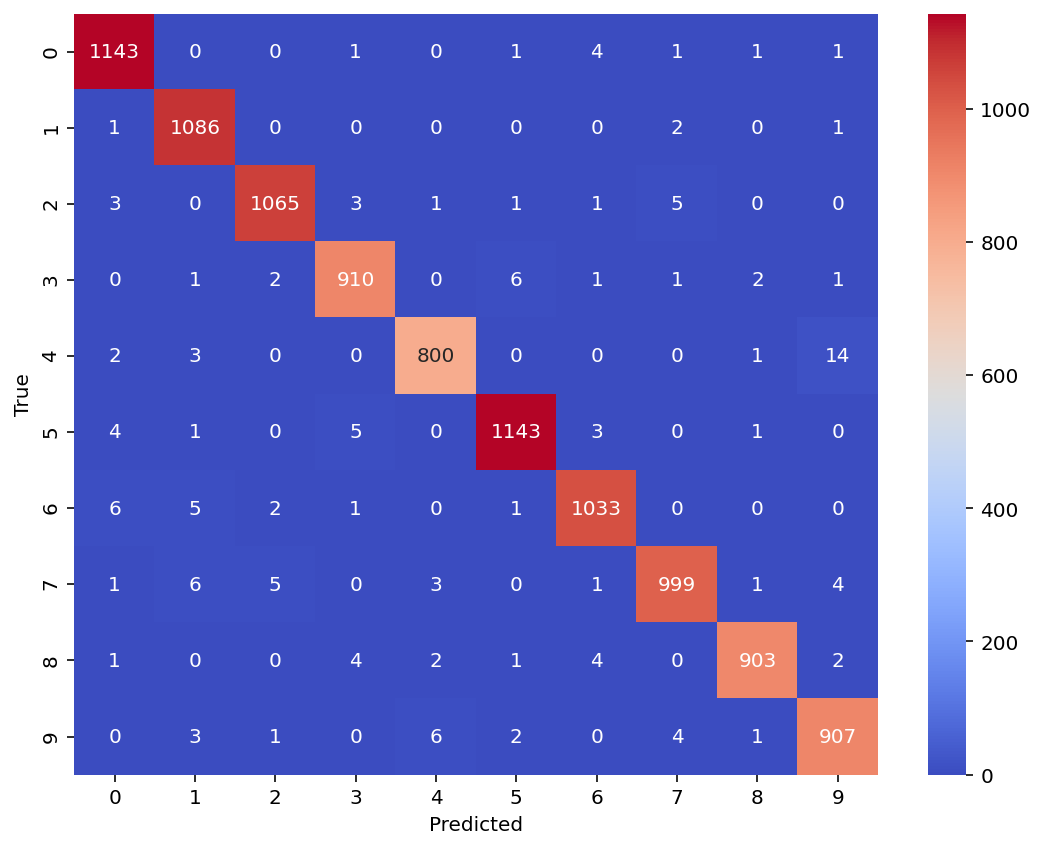

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1152
         1.0       0.98      1.00      0.99      1090
         2.0       0.99      0.99      0.99      1079
         3.0       0.98      0.98      0.98       924
         4.0       0.99      0.98      0.98       820
         5.0       0.99      0.99      0.99      1157
         6.0       0.99      0.99      0.99      1048
         7.0       0.99      0.98      0.98      1020
         8.0       0.99      0.98      0.99       917
         9.0       0.98      0.98      0.98       924

    accuracy                           0.99     10131
   macro avg       0.99      0.99      0.99     10131
weighted avg       0.99      0.99      0.99     10131

CV Accuracy Score=0.9859836146481098
model=resnet34, optimizer=adam, epochs=250, lr=0.0005, wd=0.0005, seed=43
Epoch=0, Train loss=3.21677, Valid loss=1.99076, Train Accuracy=0.22131, Validation Accuracy=0.30898
Epoch=10, Train loss=1.74152,

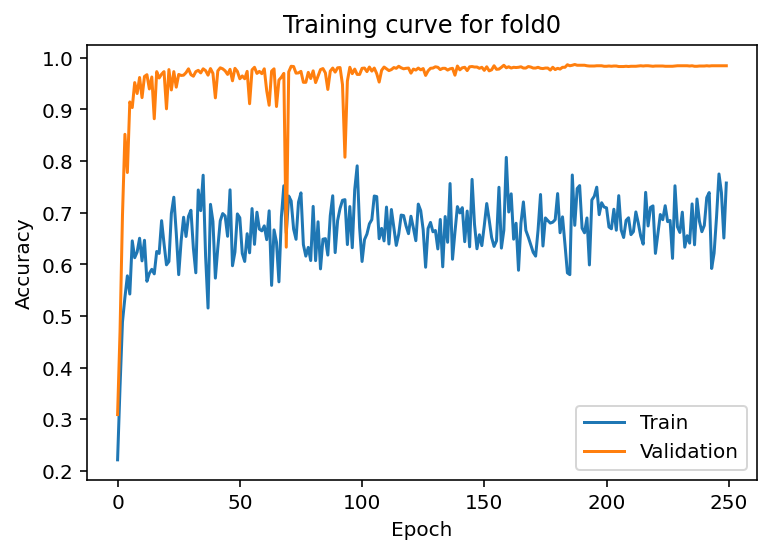

Epoch=0, Train loss=3.11132, Valid loss=1.27727, Train Accuracy=0.26653, Validation Accuracy=0.56910
Epoch=10, Train loss=1.64295, Valid loss=0.49641, Train Accuracy=0.64418, Validation Accuracy=0.93435
Epoch=20, Train loss=1.60631, Valid loss=0.65606, Train Accuracy=0.67011, Validation Accuracy=0.97384
Epoch=30, Train loss=1.58735, Valid loss=0.53925, Train Accuracy=0.67014, Validation Accuracy=0.97285
Epoch=40, Train loss=1.72585, Valid loss=0.61057, Train Accuracy=0.60722, Validation Accuracy=0.96644
Epoch=50, Train loss=1.50974, Valid loss=0.46775, Train Accuracy=0.69845, Validation Accuracy=0.97976
Epoch=60, Train loss=1.36148, Valid loss=0.56946, Train Accuracy=0.74695, Validation Accuracy=0.96446
Epoch=70, Train loss=1.47234, Valid loss=0.83165, Train Accuracy=0.70303, Validation Accuracy=0.96545
Epoch=80, Train loss=1.55054, Valid loss=0.64449, Train Accuracy=0.68129, Validation Accuracy=0.97878
Epoch=90, Train loss=1.50815, Valid loss=0.47916, Train Accuracy=0.69019, Validatio

In [ ]:
for seed in range(43, 50):
    seed_everything(seed)

    model_name = "resnet34"
    optim_name = "adam"
    epochs = 250
    lr = 5e-4
    wd = 5e-4
    swa_lr = 5e-5
    batch_size = 128

    oof, targs = run_pl_swa(
        pl,
        model_name,
        optim_name,
        epochs,
        lr,
        swa_lr,
        wd,
        batch_size,
        augs,
        label_smooth=True,
        cutmix=True,
        device=DEVICE,
        seed=seed,
    )
    preds = np.argmax(oof, axis=1)
    accuracy = metrics.accuracy_score(targs, preds)
    print(f"CV Accuracy Score={accuracy}")
    print(
        f"model={model_name}, optimizer={optim_name}, epochs={epochs}, lr={lr}, wd={wd}, seed={seed}"
    )

    checkpoints = [f"./swa_resnet34_fold{fold}_pl_seed{seed}.pth" for fold in range(5)]
    model_names = ["resnet34"] * 5
    test_df = pd.read_csv(DATA_PATH / "test.csv")
    test_probs = infer(
        model_names, checkpoints, test_df, device=DEVICE, augs=augs, tta=True
    )
    test_preds = np.argmax(test_probs, axis=1)
    np.save(f"swa_tta_pl_probs_resnet34_seed{seed}.npy", test_probs)

### Bagging

In [ ]:
test_probs_lst = [f"swa_tta_pl_probs_resnet34_seed{seed}.npy" for seed in range(42, 50)]

test_probs = np.zeros((len(test_df), 10))
for test_prob_path in test_probs_lst:
    test_probs += np.load(test_prob_path) / len(test_probs_lst)
np.save("ensemble_swa_tta_pl_probs_resnet34.npy", test_probs)

In [ ]:
test_probs = np.load("ensemble_swa_tta_pl_probs_resnet34.npy")
test_preds = np.argmax(test_probs, axis=1)
submit = pd.DataFrame({"id": test_df.id.values, "digit": test_preds})
submit.to_csv("ensemble_swa_tta_pl_submit_resnet34.csv", index=False)